In [1]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
import imageio
%matplotlib inline
from ipywidgets import interactive, widgets
import time

In [2]:
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-01-01 09:55:51--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-01-01 09:55:52--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz.14’

tiny_nerf_data.npz. 100%[===================>]  12.14M  6.24MB/s    in 1.9s    

2024-01-01 09:55:54 (6.24 MB/s) - ‘tiny_nerf_data.npz.14’ saved [12727482/12727482]



In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Print the exception if memory growth setting fails
        print(e)

Images shape:  (106, 100, 100, 3)
Poses shape:  (106, 4, 4)


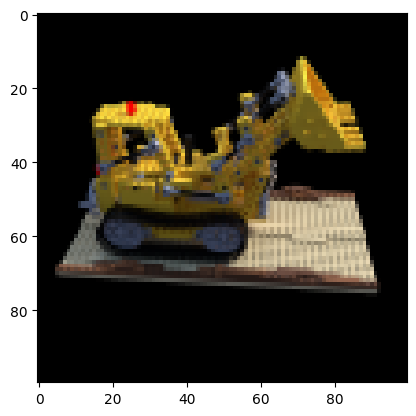

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print("Images shape: ", images.shape)
print("Poses shape: ", poses.shape)

testimg, testpose = images[90], poses[90]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [5]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity



def init_model(D=8, W=256, L_embed=L_embed):
    """
    Initialize a TensorFlow model.

    Parameters:
    D (int): Number of dense layers in the model.
    W (int): Width of each dense layer (number of neurons).
    L_embed (int): Embedding length, used in the input shape calculation.

    Returns:
    tf.keras.Model: A TensorFlow Keras model.
    """

    # Define a ReLU activation function
    relu = tf.keras.layers.ReLU()

    # A helper function to create dense layers with specified width and activation
    def dense_layer(W=W, activation=relu):
        return tf.keras.layers.Dense(W, activation=activation)

    # Define the input shape: 3 features + 3*2*L_embed for embeddings
    input_shape = (3 + 3*2*L_embed,)
    inputs = tf.keras.Input(shape=input_shape)

    # Initialize outputs variable with the input layer
    outputs = inputs

    # Add 'D' dense layers to the model
    for i in range(D):
        outputs = dense_layer()(outputs)

        # Every 4th layer (excluding the first), concatenate the outputs with the inputs
        if i % 4 == 0 and i > 0:
            outputs = tf.concat([outputs, inputs], axis=-1)

    # Add a final dense layer with 4 units and no activation function
    outputs = dense_layer(W=4, activation=None)(outputs)

    # Create the Keras model with the specified inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model





def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, batch_size, rand=False):

    # def batchify(fn, chunk=1024*32):
    #     return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    def batchify(fn,inputs,chunk=batch_size):
        output = []
        for i in range(0, inputs.shape[0], chunk):
            output.append(fn(inputs[i:i+chunk]))
        return tf.concat(output, 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn,pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

0 0.6744000053405762 secs per iter


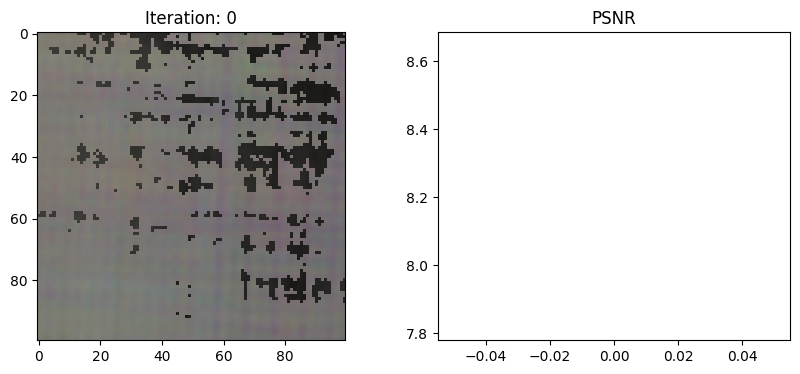

25 2.1434398460388184 secs per iter


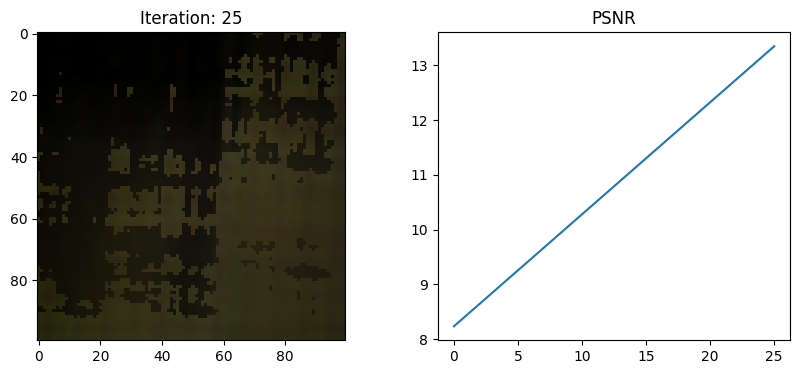

50 2.1851791191101073 secs per iter


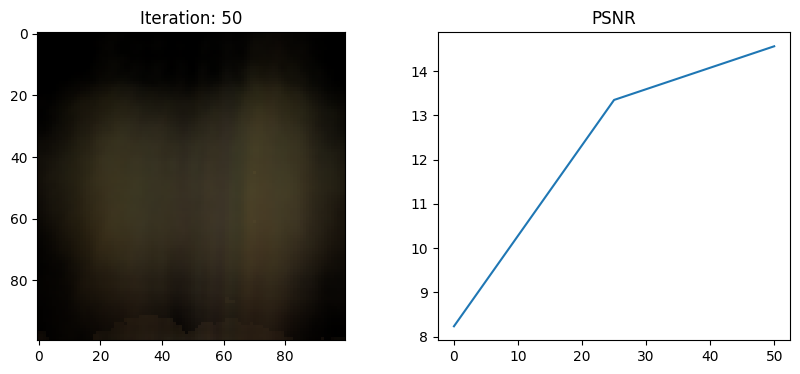

75 2.1230690383911135 secs per iter


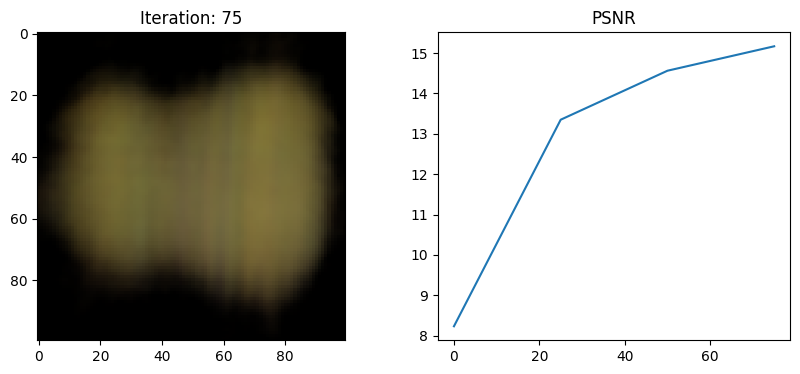

100 2.129730014801025 secs per iter


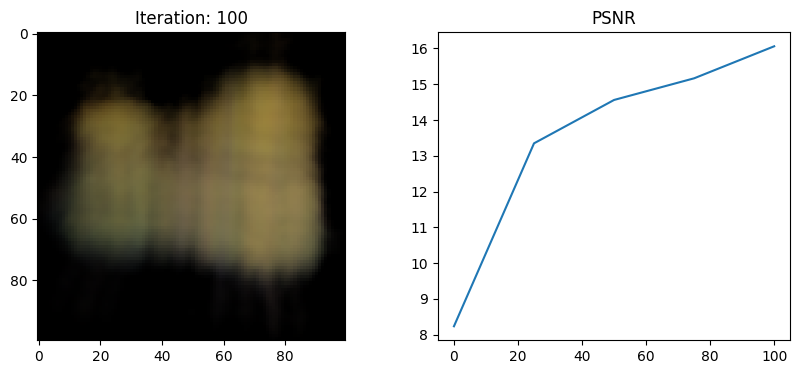

125 2.126993637084961 secs per iter


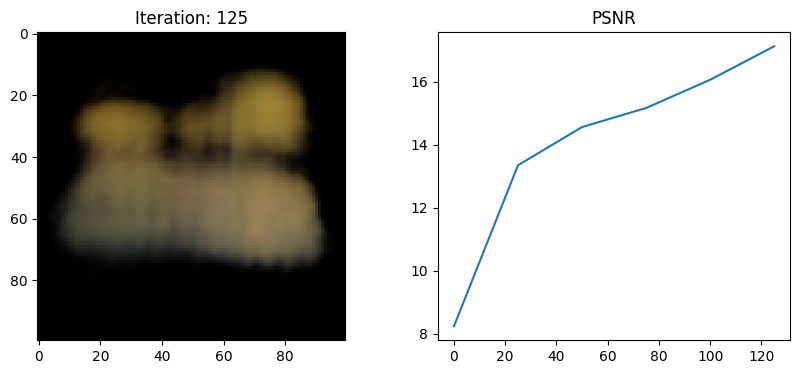

150 2.1532117080688478 secs per iter


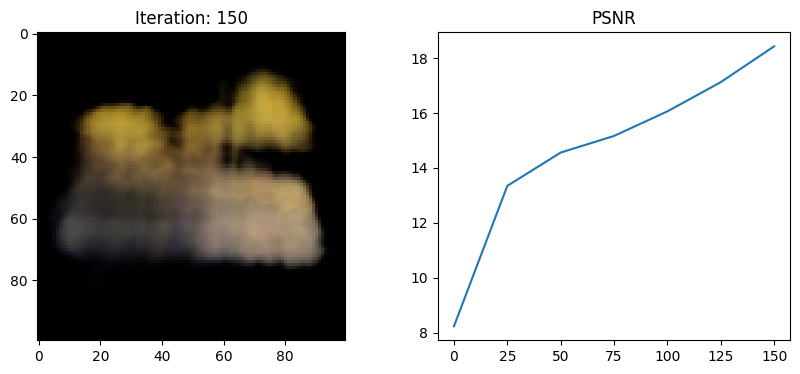

175 2.131517572402954 secs per iter


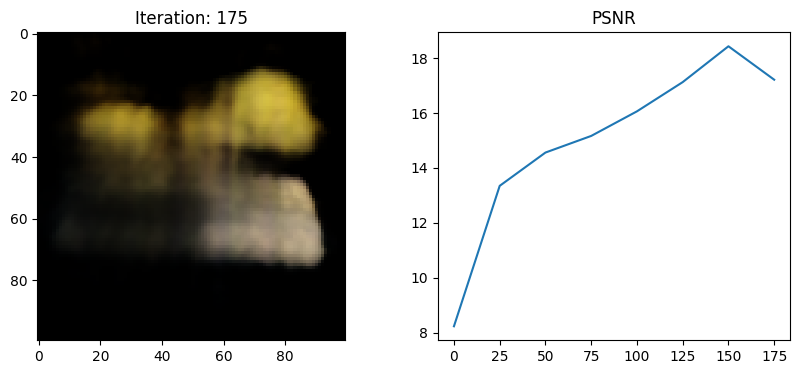

200 2.1552779865264893 secs per iter


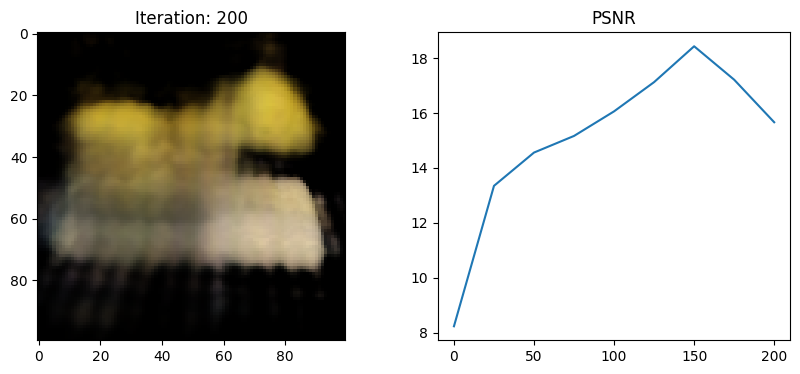

225 2.133437042236328 secs per iter


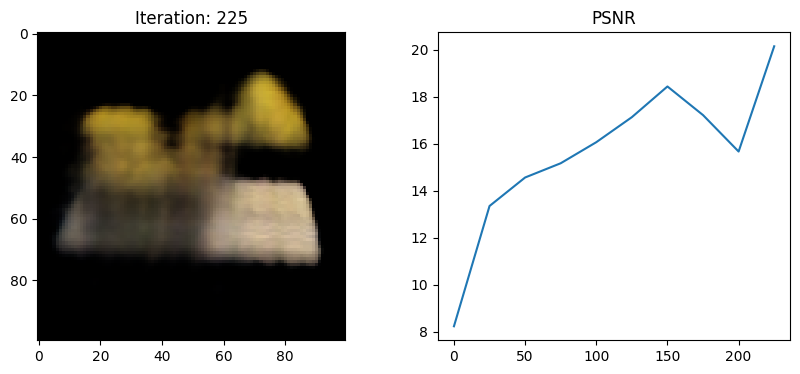

250 2.156848316192627 secs per iter


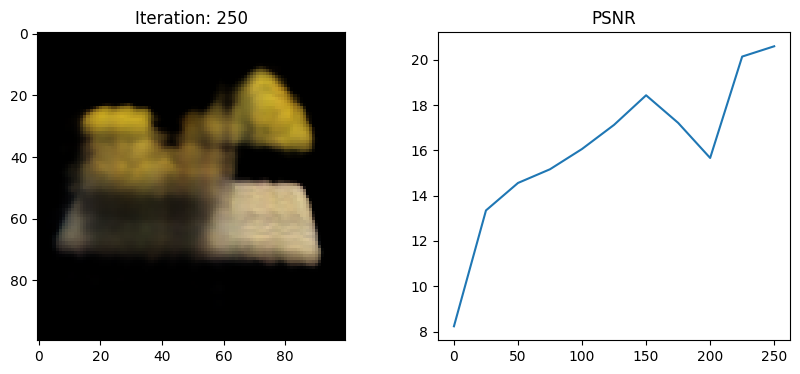

275 2.235519790649414 secs per iter


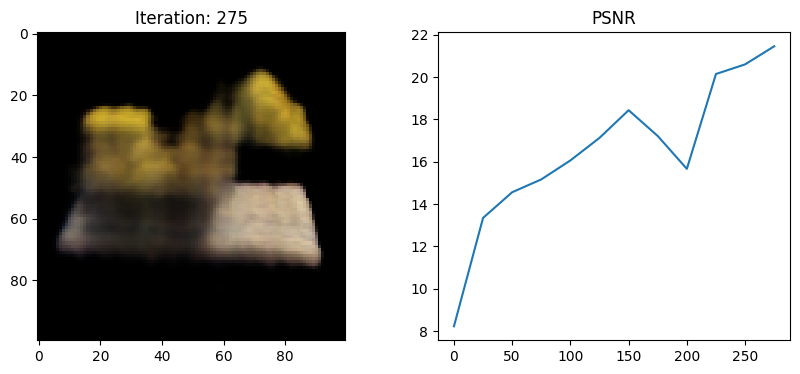

300 2.150169038772583 secs per iter


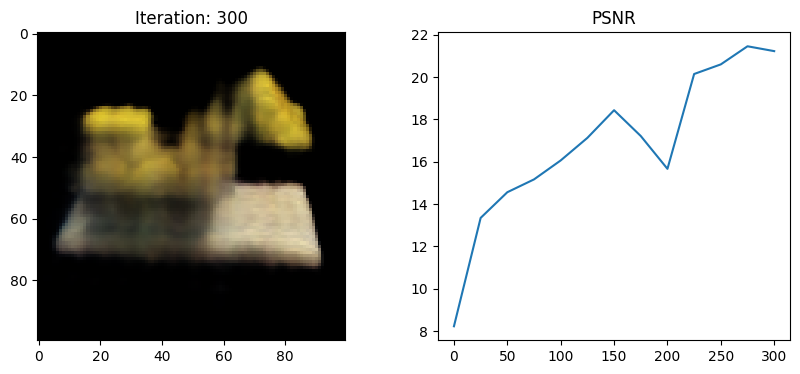

325 2.1544525718688963 secs per iter


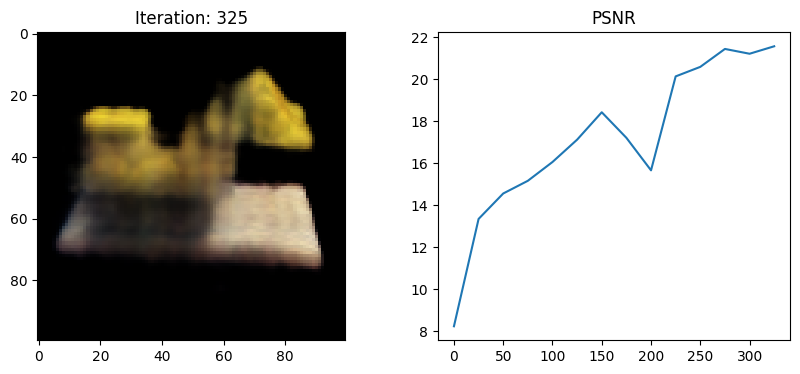

350 2.171984281539917 secs per iter


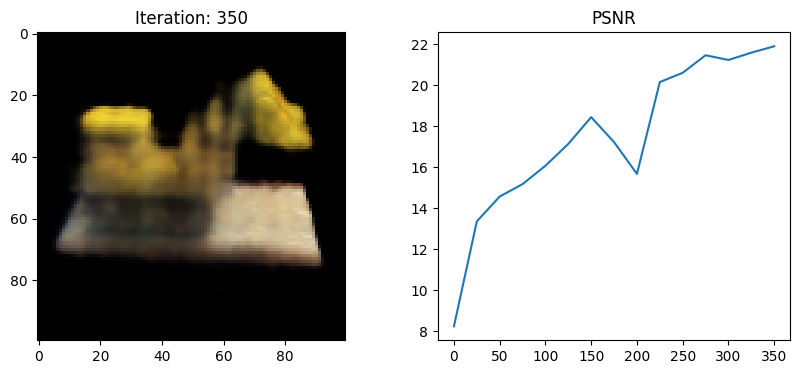

375 2.193652448654175 secs per iter


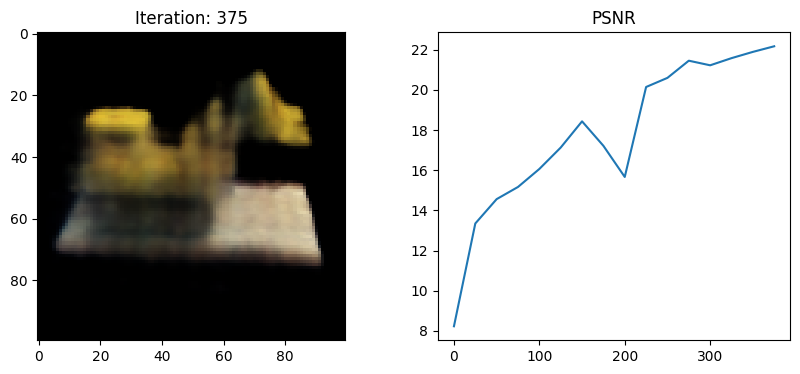

400 2.167365312576294 secs per iter


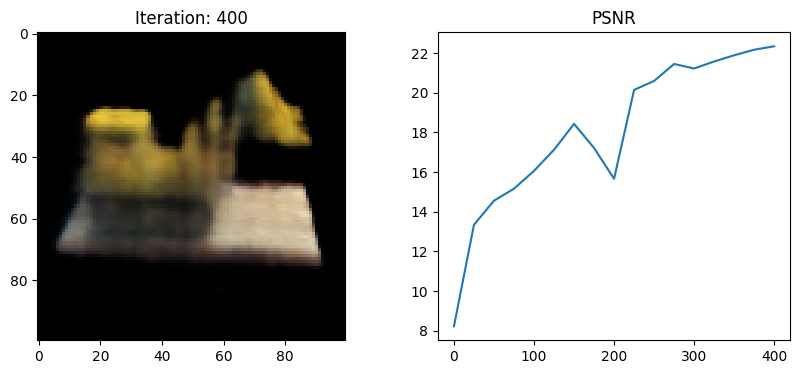

425 2.164487066268921 secs per iter


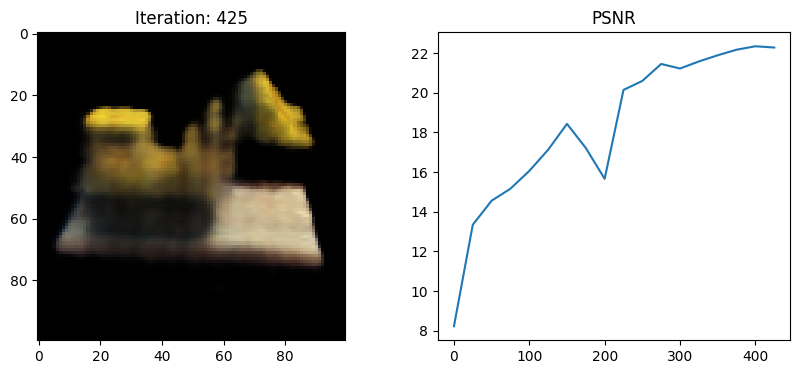

450 2.1790884017944334 secs per iter


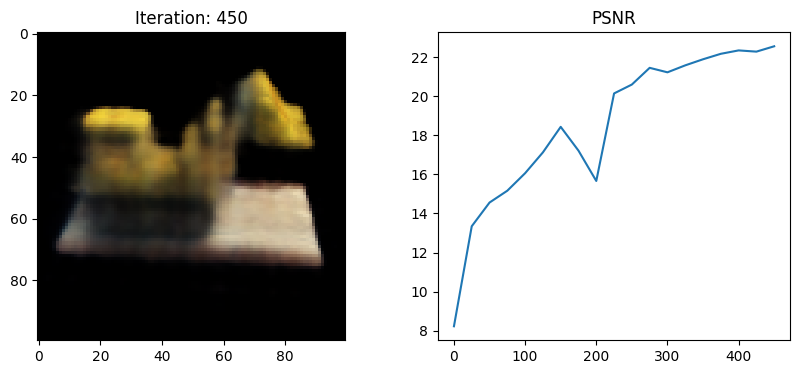

475 2.2579355144500735 secs per iter


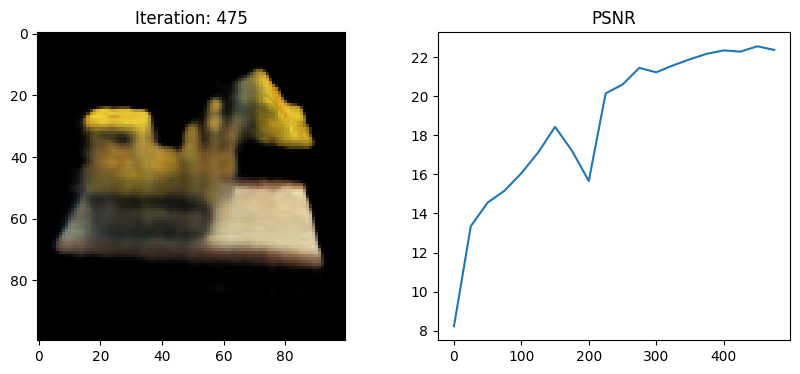

500 2.191108512878418 secs per iter


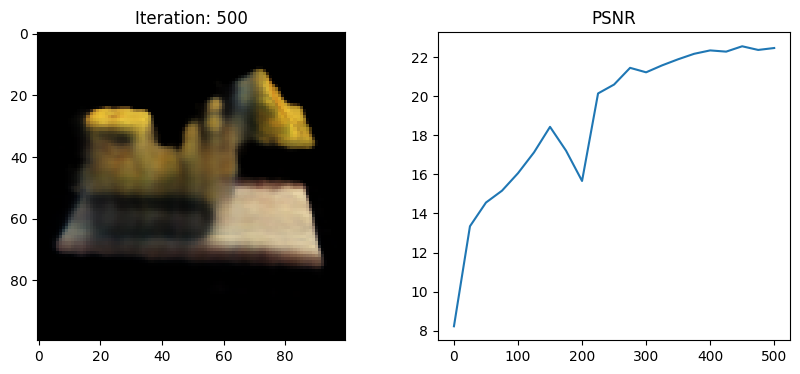

525 2.180666208267212 secs per iter


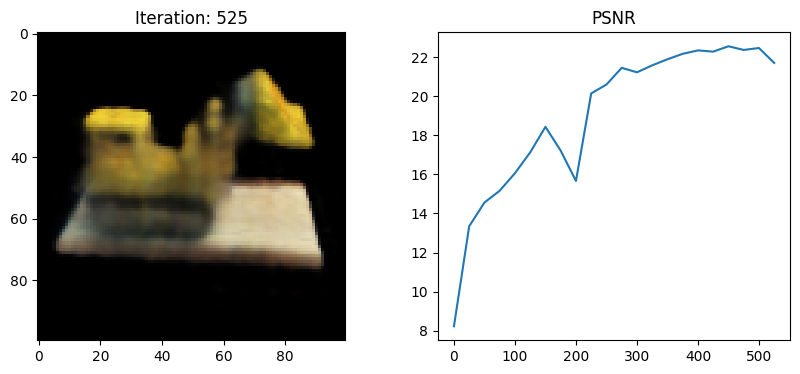

550 2.263327941894531 secs per iter


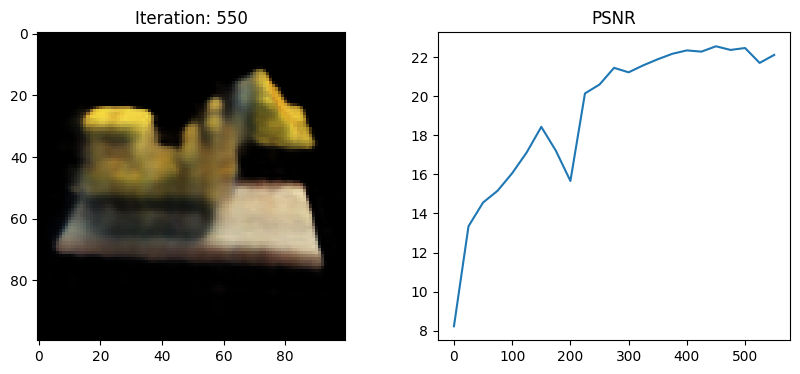

575 2.1810857391357423 secs per iter


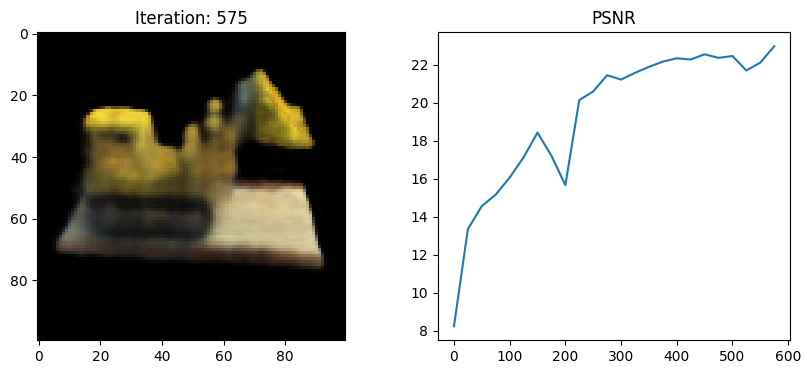

600 2.1727177047729493 secs per iter


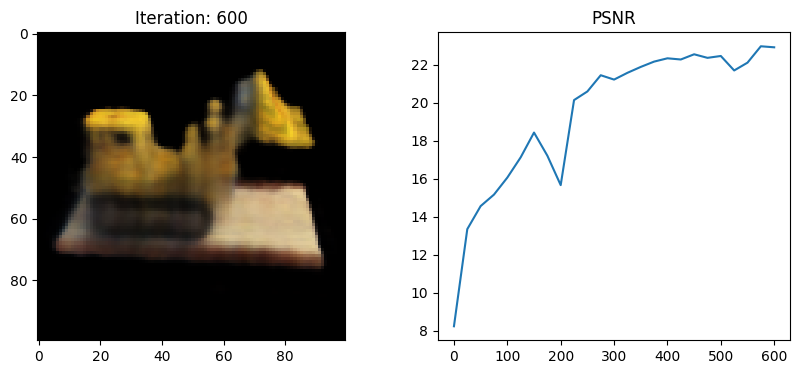

625 2.1712290954589846 secs per iter


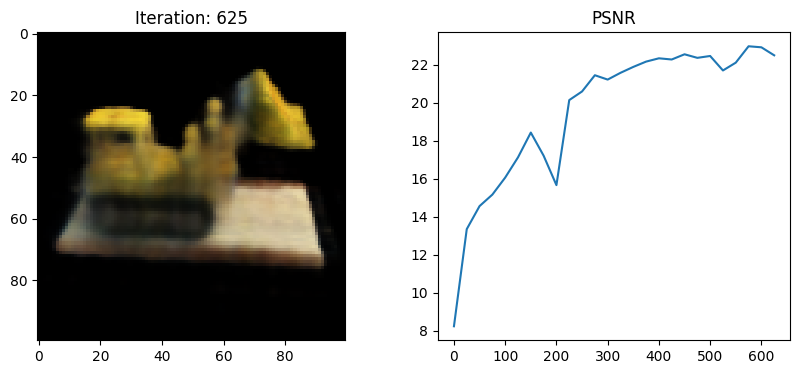

650 2.215497169494629 secs per iter


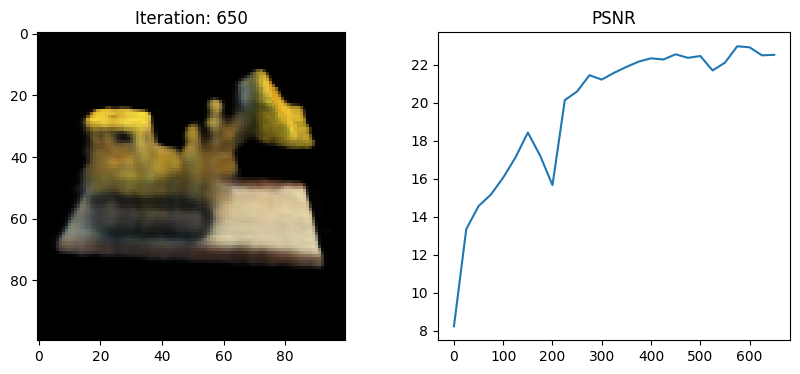

675 2.1744978618621826 secs per iter


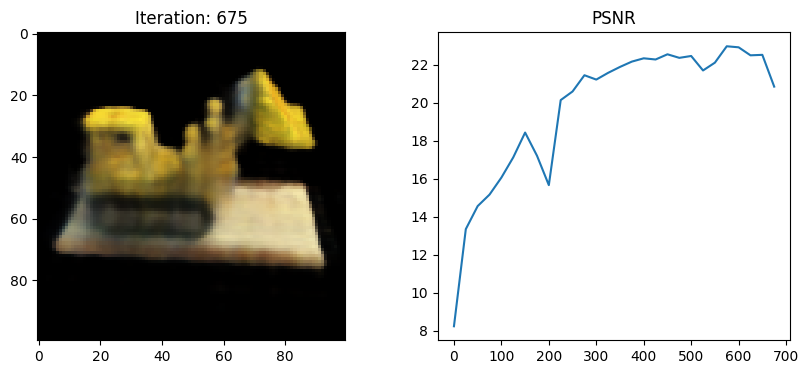

700 2.1840763187408445 secs per iter


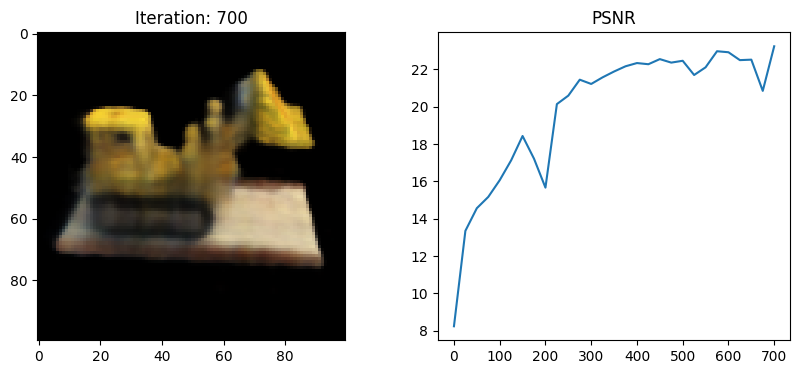

725 2.1854267597198485 secs per iter


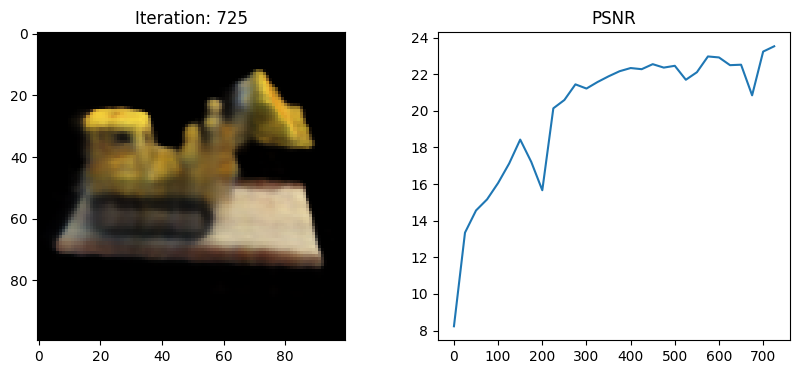

750 2.1891074848175047 secs per iter


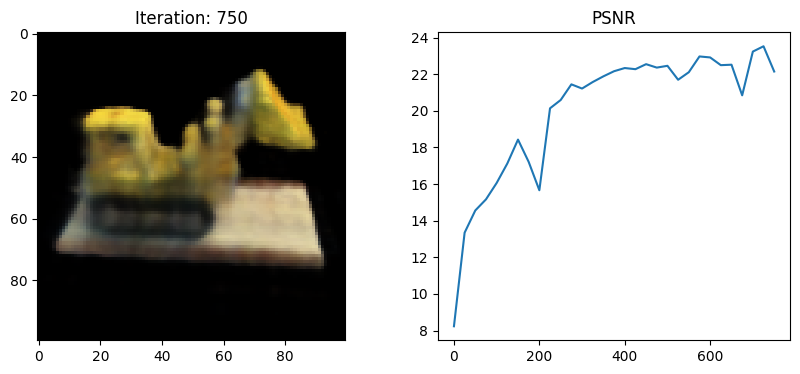

775 2.1735700511932374 secs per iter


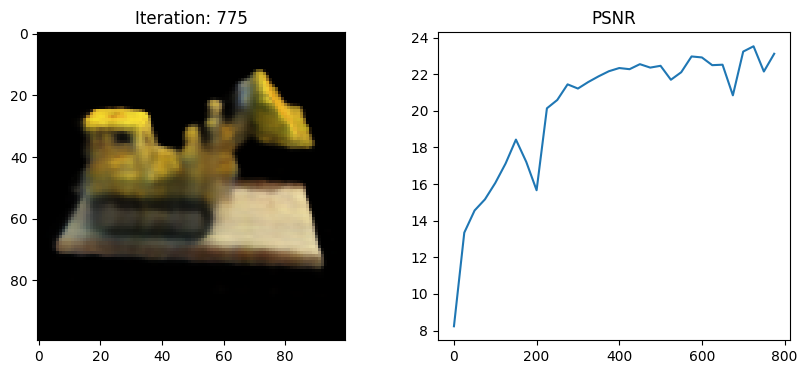

800 2.19398588180542 secs per iter


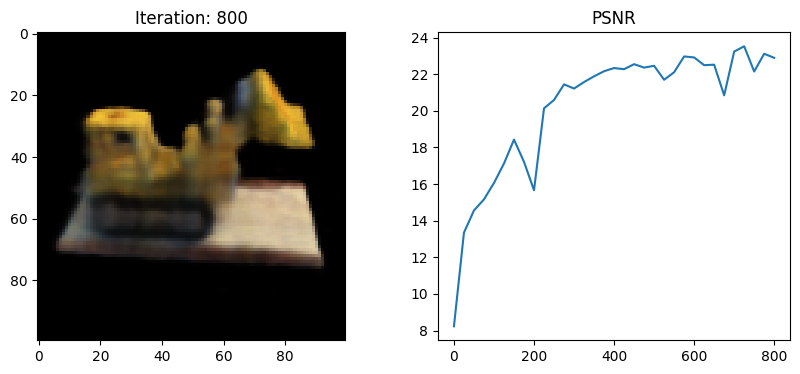

825 2.2563242721557617 secs per iter


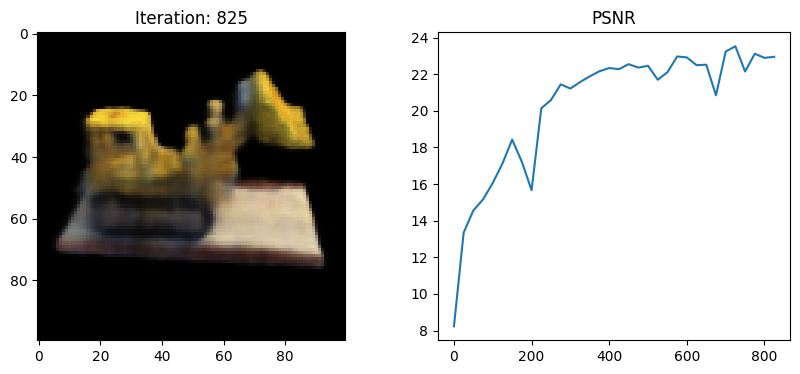

850 2.1954631996154785 secs per iter


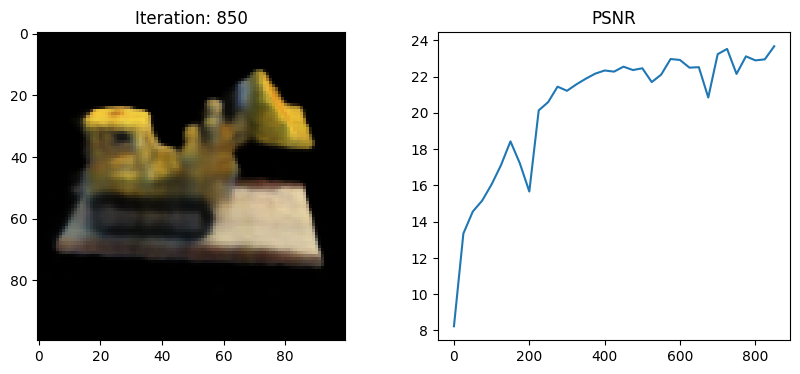

875 2.180672903060913 secs per iter


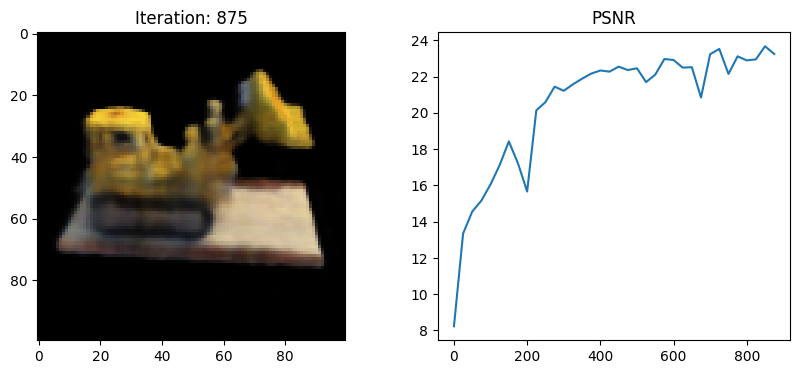

900 2.225572624206543 secs per iter


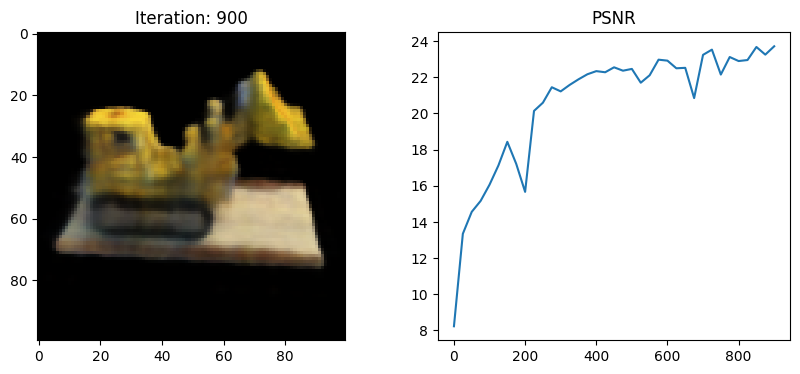

925 2.1837171363830565 secs per iter


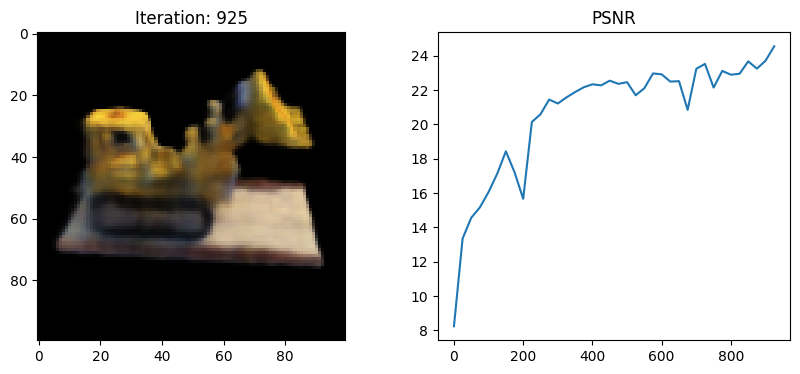

950 2.1897949886322023 secs per iter


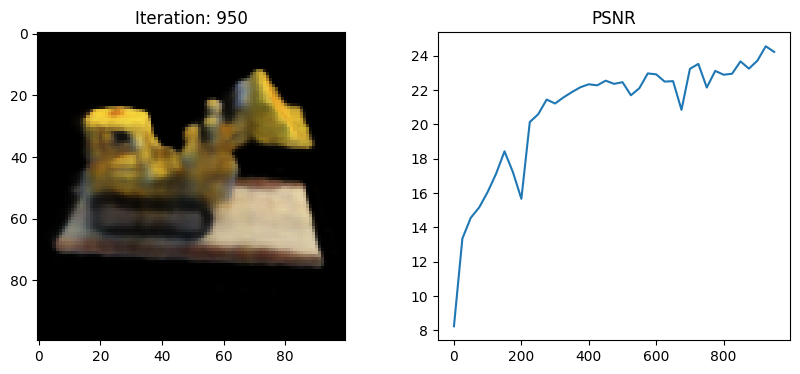

975 2.190811767578125 secs per iter


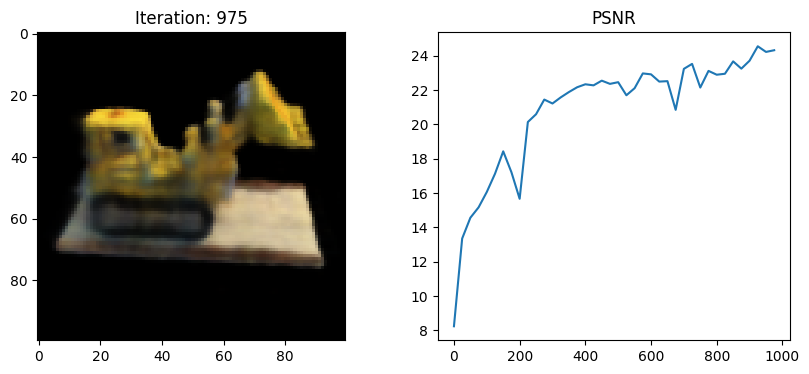

1000 2.177018051147461 secs per iter


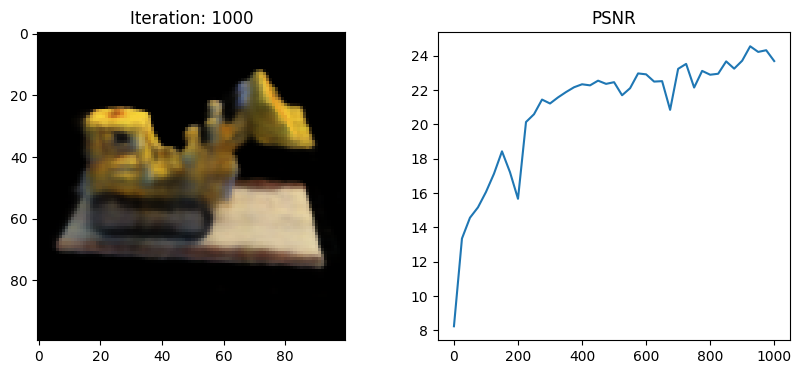

Done


In [6]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25
batch_size=64*64


t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

In [7]:


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, batch_size=batch_size)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))


<ipython-input-7-a677254f1f78>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [8]:
f = 'mlp_base.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

mp4 = open('mlp_base.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)